In [333]:
import numpy as np
import structures 
import random

from math import sqrt
from matplotlib import pyplot as plt
from structures import Model
from math import sqrt

In [294]:
EPS = 0.1
EPS_DIFF = 0.01

In [325]:
def smape(dataset, weights):
    summ = 0.0
    
    #           1     2*|a(xi) - yi|
    # SMAPE = ---- * -----------------
    #          |D|      |a(xi)|+|yi|
    for row in range(dataset.data_amount):
        y = dataset.targets[row]
        a = np.sum(dataset.features[row] * weights)
        summ = summ + 2 * (abs(a - y) / (abs(a) + abs(y)))
    return summ / dataset.data_amount


def nrmse(dataset, weights):
    
    #                    SUM (y^ - yt)^2
    # RMSD = sqrt(  -------------------- )
    #                        T
    summ = 0.0
    for row in range(dataset.data_amount):
        yt = dataset.targets[row]
        yh = np.sum(dataset.features[row] * weights)
        summ = summ + (yh - yt) ** 2
    rmse = sqrt(summ / dataset.data_amount)
    return rmse / get_quartiles(dataset.targets)


def get_quartiles(targets):
    arranged_targets = np.sort(targets)
    values_amount = len(arranged_targets)
    quartile1 = arranged_targets[values_amount // 4]
    quartile3 = arranged_targets[3 * values_amount // 4]
    return quartile3 - quartile1


def resulting(dataset, method):
    smapeV = smape(dataset, method[0])
    nrmseV = nrmse(dataset, method[0])
    print("Best regularisation: %s" % method[1])
    print("SMAPE  " + str (smapeV))
    print("NRMSE  " + str (nrmseV)+"\n")


In [296]:
# Нормализаци 

def l1(vector):
    return np.sum(np.fromiter(map(lambda x: abs(x), vector), dtype=float))


def l2(vector):
    return sqrt(np.sum(np.fromiter(map(lambda x: x ** 2, vector), dtype=float)))

In [318]:
# Из сета, регуляции и типа градиента строит график

def painting(dataset, regularisation, grad_type):
    
    loss_function = grebFun
    grad_function = grebGrad, 
    
    grad_step = configure(grad_type, dataset.targets)
    initial_step = 1 / get_quartiles(dataset.targets)
    weights = initialise_weights(dataset)
    model = Model(dataset, weights, regularisation, initial_step, EPS + 1)
    losses = list()
    print("Drawing a plot")
    for iteration in range(2000):
        model.weights, model.diff_weights, converged = grad_step(model, iteration, grad_function)
        if iteration > 5:
            error = smape(dataset, model.weights)
            losses.append((iteration, error))
        if converged:
            break
    iterations = list(map(lambda x: x[0], losses))
    errors = list(map(lambda y: y[1], losses))
    plt.title("%s, regularisation = %s" % (grad_type, regularisation))
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.plot(iterations, errors)
    plt.show()
    print("\n")

In [328]:
# Блок работы с потерями

# Часть квадратного отклонения
def grebLossFun(model, item):
    f = model.features[item]
    w = model.weights
    expected = model.targets[item]
    actual = np.sum(f*w)
    return (actual - expected) ** 2

def gradLoss(model, item):
    f = model.features[item]
    w = model.weights
    expected = model.targets[item]
    actual = np.sum(f * w)
    return 2 * (actual - expected) / l2(f) * f

# Функция подсчета ошибок
def lossCounter(model, loss_func):
    return np.sum(np.fromiter(map(lambda x: loss_func(model, x), range(model.data_amount)), dtype=float))

In [329]:
# Гребневой метод
def grebFun(model, item):
    return grebLossFun(model, item) + (model.regularisation / (2 * (l2(model.weights) ** 2)))


def grebGrad(model, item):
    return gradLoss(model, item) + model.regularisation * model.weights


def sign(w):
    signed = np.empty(shape=len(w), dtype=float)
    for val in range(len(w)):
        if w[val] == 0.0:
            signed[val] = 0.0
            continue
        if w[val] > 0.0:
            signed[val] = 1.0
            continue
        signed[val] = -1.0
    return signed

In [320]:
def initialise_weights(dataset):
    weights = np.empty(shape=dataset.features_amount)
    for col in range(dataset.features_amount):
        squared_norm = np.sum(dataset.features[:, col] * dataset.features[:, col])
        weights[col] = np.sum(dataset.targets * dataset.features[:, col]) / squared_norm
    return weights


def gradComp(dataset, reg, grad_type):
    loss_function, grad_function, grad_step = configure(grad_type, dataset.targets)
    initial_step = 1 / get_quartiles(dataset.targets)
    print("Regularisation : %s\n" % reg)
    weights = initialise_weights(dataset)
    model = Model(dataset, weights, reg, initial_step, EPS + 1.0)
    for iteration in range(2000):
        model.weights, model.diff_weights, converged = grad_step(model, iteration, grad_function)
        if converged:
            break
    print("\n")
    err = lossCounter(model, loss_function)
    return model.weights, reg, err


def stochStep(model, iteration, grad_function):
    gradient_step = model.initial_grad / (iteration + 1)
    selected = random.randint(0, model.data_amount - 1)
    local_gradient = grad_function(model, selected)
    new_weights = model.weights - gradient_step * local_gradient
    diff_weights = l1(new_weights - model.weights)
    if (diff_weights < EPS and model.diff_weights < EPS) or \
            abs(model.diff_weights - diff_weights) < EPS_DIFF:
        return new_weights, diff_weights, True
    return new_weights, diff_weights, False


def clasStep(model, iteration, grad_function):
    gradient_step = model.initial_grad / (iteration + 1)
    local_gradient = np.zeros(shape=model.features_amount, dtype=float)
    for row in range(model.data_amount):
        local_gradient += grad_function(model, row)
    local_gradient /= model.data_amount
    new_weights = model.weights - gradient_step * local_gradient
    diff_weights = l1(new_weights - model.weights)
    if (diff_weights < EPS and model.diff_weights < EPS) or \
            abs(model.diff_weights - diff_weights) < EPS_DIFF:  
        return new_weights, diff_weights, True
    return new_weights, diff_weights, False


def configure(grad_type, targets):
    if grad_type == "stochastic":
        print("The Stochastic Gradient")
        return  stochStep
    if grad_type == "classic":
        print("The Classic Gradient")
        return clasStep

In [330]:
def sqLt(dataset, fu):
    print(" The least squares ")
    approximations = list()
    i=0
    regularisation = 0.0
    errsm = []
    errms = []
    reg   = []    
    while regularisation <= 1.0:
        # Псевдоинверсия
        pseudo = psevd(dataset, regularisation)
        weights = pseudo.dot(dataset.targets)
        model = Model(dataset, weights, regularisation, 0.0, 0.0)
        error = lossCounter(model, fu)
        errsm.append( smape(dataset,weights))
        errms.append( nrmse(dataset,weights))
        reg.append(regularisation)
        approximations.append((weights, regularisation, error))
        regularisation = regularisation + 0.2 
        i=i+1
    plt.title("SMAPE")
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.plot(reg, errsm,label='S')
    plt.show()
    print("\n")
    plt.plot(reg, errms, label='M')
    plt.show()
    print("\n")
    approximations.sort(key=lambda x: x[2])
    print("  The Least squares finished \n")
    return approximations[0], i


def psevd(dataset, regularisation):
    amount = dataset.features_amount
    reg_matrix = np.zeros(shape=(amount, amount), dtype=float)
    matrix = dataset.features
    for i in range(amount):
        reg_matrix[i, i] = regularisation
    return np.linalg.inv(matrix.transpose().dot(matrix) 
                         + reg_matrix).dot(matrix.transpose())


In [302]:
# Заполнение таблиц

# Заполнение таблицы
def parse(offset, objects_amount):
    features = np.empty(shape=(objects_amount, features_amount), dtype=float)
    targets = np.empty(shape=objects_amount)
    for i in range(objects_amount):
        row = data[i + offset].split()
        for j in range(features_amount):
            features[i, j] = int(row[j])
        targets[i] = row[features_amount]
    return features, targets

#
def add_const_feature(features):
    temp = list()
    temp.append(np.ones(shape=len(features), dtype=float))
    for col in range(len(features[0])):
        temp.append(features[:, col])
    return np.array(temp).transpose()

# Поиск идентичных признаков
def seek_identical(features):
    useless_features = np.zeros(shape=features_amount, dtype=bool)
    for col in range(features_amount):
        if len(np.unique(features[:, col])) == 1:
            useless_features[col] = True
    return useless_features

# Удаление идентичных признаков
def delete_identical(features):
    temp = list()
    for col in range(features_amount):
        if useless_features[col]:
            continue
        temp.append(features[:, col])
    new_dataset = np.array(temp).transpose()
    return new_dataset


def apprex(approximation):
    new_approximation = np.empty(shape=features_amount + 1)
    j = 0
    new_approximation[0] = approximation[0][0]
    for i in range(features_amount):
        if not useless_features[i]:
            new_approximation[i + 1] = approximation[0][j + 1]
            j += 1
        new_approximation[i + 1] = 0.0
    return new_approximation, approximation[1], approximation[2]


In [303]:
file = open("LR/1.txt", "r")
data = file.readlines()
file.close()

# Сбор кол-ва признаков
features_amount = int(data[0])
training = int(data[1])

# Обработка входных данных
train_features, train_targets = parse(2, training)
useless_features = seek_identical(train_features)
train_features = delete_identical(train_features)
train_features = add_const_feature(train_features)
print(train_features)
train_dataset = structures.Dataset(train_features, train_targets)


# Подбор гиперпараметров
stoch = []
classic = []

regularisation = 0.0
while regularisation <= 1.0:
    stoch.append(apprex(gradComp(train_dataset, regularisation, "stochastic")))
    classic.append(apprex(gradComp(train_dataset, regularisation, "classic")))
    regularisation = regularisation + 0.2

[[ 1.000000e+00  8.618130e+05 -1.096890e+05 ...  2.727628e+06
   6.259280e+06 -1.385520e+05]
 [ 1.000000e+00  7.348970e+05 -1.097010e+05 ...  2.693318e+06
   6.219628e+06 -1.386310e+05]
 [ 1.000000e+00  8.930090e+05 -1.096530e+05 ...  2.704943e+06
   6.223772e+06 -1.394840e+05]
 ...
 [ 1.000000e+00 -1.280786e+06 -1.097020e+05 ...  2.093540e+06
   5.526842e+06 -1.533830e+05]
 [ 1.000000e+00 -9.084710e+05 -1.096410e+05 ...  2.183722e+06
   5.630057e+06 -1.549650e+05]
 [ 1.000000e+00 -1.307243e+06 -1.096630e+05 ...  2.055455e+06
   5.474715e+06 -1.551360e+05]]
The Stochastic Gradient
Regularisation : 0.0



The Classic Gradient
Regularisation : 0.0



The Stochastic Gradient
Regularisation : 0.2



The Classic Gradient
Regularisation : 0.2



The Stochastic Gradient
Regularisation : 0.4



The Classic Gradient
Regularisation : 0.4



The Stochastic Gradient
Regularisation : 0.6000000000000001



The Classic Gradient
Regularisation : 0.6000000000000001



The Stochastic Gradient
Regularisa

 The least squares 


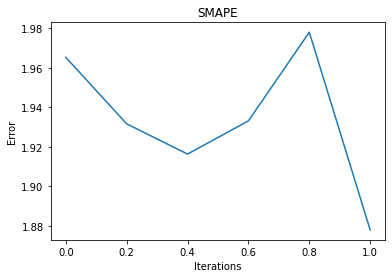

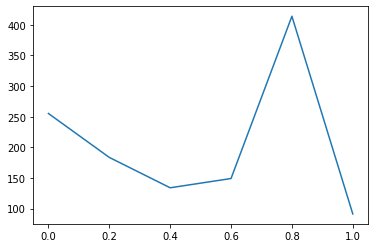



  The Least squares finished 

  Estimating least squares 
Best regularisation: 1.0
SMAPE: 1.9999999999031923
NRMSE: 157493773.4567679

         The Best stochastic gradient       
Best regularisation: 0.0
SMAPE: 1.890492309905285
NRMSE: 129.78905750449036

      The Best classic gradient        
Best regularisation: 1.0
SMAPE: 1.4922521590999909
NRMSE: 10.67636996855937

The Stochastic Gradient
Drawing a plot


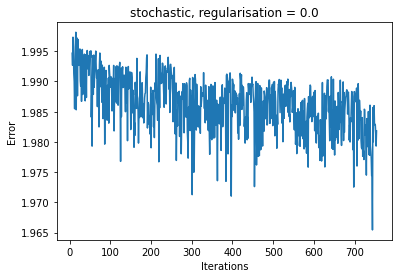



The Classic Gradient
Drawing a plot


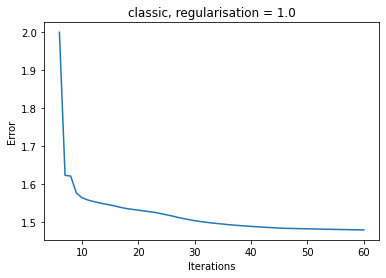

In [306]:
stochastic_approximations.sort(key=lambda x: x[2])
classic_approximations.sort(key=lambda x: x[2])
best_stochastic = stochastic_approximations[0][0], stochastic_approximations[0][1]
best_classic = classic_approximations[0][0], classic_approximations[0][1]

apr, itera = sqLt(train_dataset, grebFun)
best_squares = apprex(apr)

test_amount = int(data[training + 2])
test_features, test_targets = parse(training + 3, test_amount)
test_features = add_const_feature(test_features)
test_dataset = structures.Dataset(test_features, test_targets)

print("  Estimating least squares ")
resulting(test_dataset, best_squares)
print("         The Best stochastic gradient       ")
resulting(test_dataset, best_stochastic)
print("      The Best classic gradient        ")
resulting(test_dataset, best_classic)

painting(test_dataset, best_stochastic[1], "stochastic")
painting(test_dataset, best_classic[1], "classic")